In [12]:
using Gen, Statistics, Memoize, Distributions, Plots

In the following example we can clearly see that the best move for the agent, given he can perform 4 steps, would be going right, as it can result in total of $9.7$ points, whereas going left will result in a maximum of $-0.1$ points. However, the agent still consistently chooses to go left because for the first state this would result in higher reward, thus the inference lowers the probabilty of drawing right from the posterior, therefore the option of going right is never drawn and so never explored.

In [18]:
FORCE = 10

function transition(state,action)
    return state+action
end

function utility(state)
  if state == 3
    return 10
  elseif state == -1
    return 0
  else
    return -0.1
  end
end

function make_agent()
  @gen function act(state,time_left)
    action = @trace(uniform_discrete(-1,1),:action)
    eu = expected_utility(state,action,time_left)
    @trace(bernoulli(exp(FORCE*eu)),:factor)
    return action
  end

  @memoize function run_act(state, time_left)
      actions = []
      trace, = generate(act, (state,time_left), choicemap((:factor,1)))
      for i = 1:1000
          trace, = Gen.mh(trace, select(:action))
          push!(actions, get_retval(trace))
      end
      return actions
  end

  @gen function reward(state, action, time_left)
      next_state = transition(state, action)
      actions = run_act(state, time_left)
      rand_choice = @trace(uniform_discrete(1, length(actions)), :rand_choice)
      next_action = actions[rand_choice]
      return expected_utility(next_state, next_action, time_left)
  end

  @memoize function run_reward(state, action, time_left)
      rewards = []
      trace, = generate(reward, (state, action, time_left))
      for i = 1:1000
          trace, = Gen.mh(trace, select(:rand_choice))
          push!(rewards, get_retval(trace))
      end
      return rewards
  end

  @memoize function expected_utility(state,action,time_left)
      u = utility(state)
      new_time_left = time_left - 1
      if new_time_left == 0
          return u
      else
          return u + mean(run_reward(state, action, new_time_left))
      end
  end
  return run_act
end;

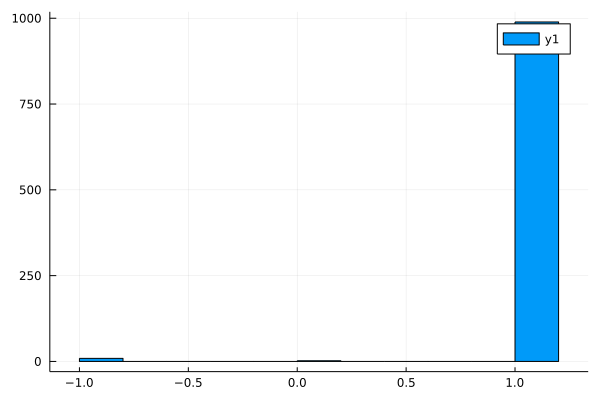

In [19]:
run_act = make_agent()
start_state = 0
total_time = 4
actions = run_act(start_state, total_time)
rand_choice = rand(DiscreteUniform(1, length(actions)))
next_action = actions[rand_choice]
histogram(actions)